In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
# Create a Dataframe and drop extra column
df = pd.read_csv('./data/features_seattle_911_no_dup_hoods.csv', low_memory=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
df.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,dt_crop,date,time,...,Wednesday,day_num,neighborhood,zone1,zone2,zone3,zone4,zone5,zone6,zone7
0,6900 37th Av S,Medic Response,2011-11-09 23:33:00,47.540683,-122.286131,"(47.540683, -122.286131)",F110104166,11/09/2011 11:33:00 PM,2011-11-09,23:33:00,...,1,498,Holly Park,0,0,0,0,0,0,1
1,N 50th St / Stone Way N,Aid Response,2011-11-09 23:32:00,47.665034,-122.340207,"(47.665034, -122.340207)",F110104164,11/09/2011 11:32:00 PM,2011-11-09,23:32:00,...,1,498,Wallingford,1,0,0,0,0,0,0
2,E John St / E Olive Way,Aid Response,2011-11-09 23:32:00,47.619575,-122.324257,"(47.619575, -122.324257)",F110104165,11/09/2011 11:32:00 PM,2011-11-09,23:32:00,...,1,498,Broadway,0,0,0,1,0,0,0
3,611 12th Av S,Aid Response,2011-11-09 23:29:00,47.597406,-122.317228,"(47.597406, -122.317228)",F110104162,11/09/2011 11:29:00 PM,2011-11-09,23:29:00,...,1,498,International District,0,0,0,0,1,0,0
4,4545 42nd Av Sw,Automatic Medical Alarm,2011-11-09 23:25:00,47.562472,-122.385455,"(47.562472, -122.385455)",F110104161,11/09/2011 11:25:00 PM,2011-11-09,23:25:00,...,1,498,Genesee,0,0,0,0,0,1,0


In [25]:
df2 = df.drop(labels=(['Address', 'Type', 'Report Location', 'Incident Number',
                 'dt_crop', 'neighborhood', 'date2', 'time2', 'weekday',
                 'Latitude', 'Longitude', 'time', 'Datetime', 'date']), axis=1)
df2.head()

,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,night,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,day_num,zone1,zone2,zone3,zone4,zone5,zone6,zone7
0,0,0,0,0,0,1,0,0,0,0,0,1,498,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,1,498,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,1,498,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,1,498,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,0,1,498,0,0,0,0,0,1,0


In [26]:
df2.to_csv('./data/model_data.csv')

In [29]:
# R used to fix dataframe for Poisson model
df3 = pd.read_csv('./data/model_data_counted.csv', low_memory=False)
df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [30]:
df3

,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,night,Monday,Saturday,Sunday,Thursday,...,Wednesday,day_num,zone1,zone2,zone3,zone4,zone5,zone6,zone7,freq
0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,1,27
2,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,1,0,23
3,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,1,0,0,29
4,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,1,0,0,0,40
5,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,1,0,0,0,0,14
6,0,0,0,0,0,0,0,0,0,0,...,0,3,0,1,0,0,0,0,0,24
7,0,0,0,0,0,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,36
8,0,0,0,0,0,0,0,0,0,0,...,0,17,0,0,0,0,0,0,0,3
9,0,0,0,0,0,0,0,0,0,0,...,0,17,0,0,0,0,0,0,1,26


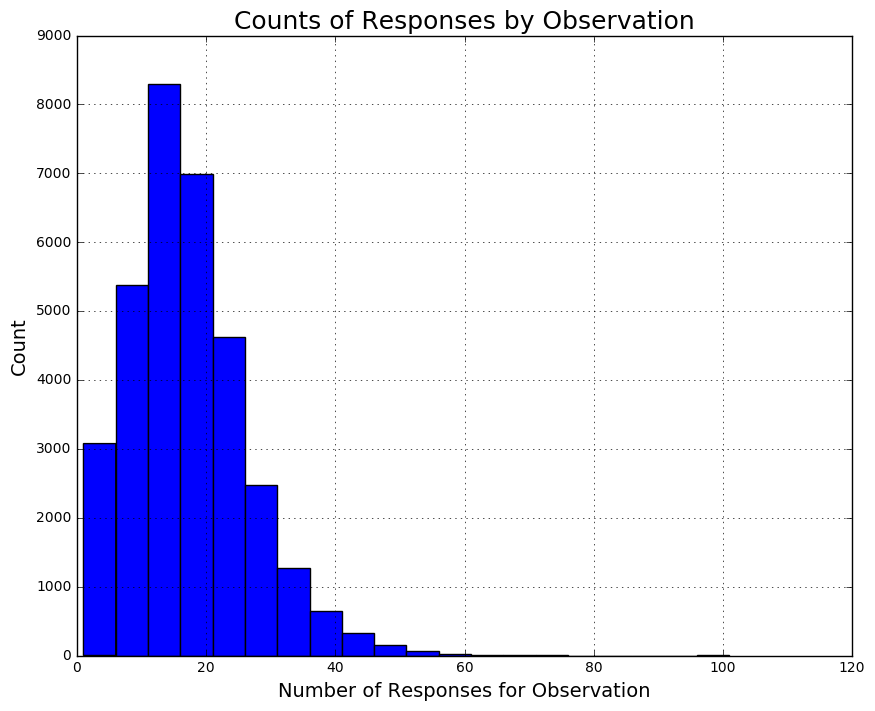

In [45]:
plt.figure(figsize=(10,8))
df3.freq.hist(bins=20)
plt.title('Counts of Responses by Observation', fontsize=18)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Number of Responses for Observation', fontsize=14)